In [1]:
(
    1 + 0
)  # Utility cell. Sometimes "Jupyter" skipps the first cell when running all cells. Especially after a restart.

1

In [2]:
(
    1 + 1
)  # Utility cell. Sometimes "Jupyter" skipps the first cell when running all cells. Especially after a restart.

2

In [3]:
print(f"N{1+2} utility cell running...")

N3 utility cell running...


In [4]:
# Resolve the path to the 'src' folder with helper functions
import config_notebooks

PYTHONPATH: C:\Users\Admin\Documents\Univer\MASTER THESIS IDEAS\Flavio Pinehro\11_MasterProject\src


In [5]:
from n03_import import *

os.getcwd():
c:\Users\Admin\Documents\Univer\MASTER THESIS IDEAS\Flavio Pinehro\11_MasterProject\notebooks
input_file_location:
..\data\02_ingested
output_file_location:
..\data\03_preprocessed


In [6]:
# # Resolve the path to the 'src' folder with helper functions
# import config_notebooks
# from importlib import reload

# # Import the module and reload it
# import n03_import_reload

# reload(n03_import_reload)

# # Re-import the functions from the reloaded module
# from n03_import_reload import *

Restoring valid_gdp_countries set of countries (big enough with significant exports)

In [7]:
# this data was staged at n01_Processed_exports.ipynb
dumped_data = restore_cache(input_file_location=input_file_location)

data restored:['valid_gdp_country_codes', 'valid_gdp_country_ids', 'valid_gdp_locations', 'export_years', 'unreliable_locations', 'rolling_exports_years', 'reliable_gdp_codes']


In [8]:
dumped_data.keys()

dict_keys(['valid_gdp_country_codes', 'valid_gdp_country_ids', 'valid_gdp_locations', 'export_years', 'unreliable_locations', 'rolling_exports_years', 'reliable_gdp_codes'])

In [9]:
valid_gdp_country_ids = set(map(str, dumped_data["valid_gdp_country_ids"]))
valid_gdp_country_codes = set(map(str, dumped_data["valid_gdp_country_codes"]))

Restoring range of observed export years

In [10]:
# Restore the range of all available years in the dataset
export_years = dumped_data["export_years"]

# Merged PARQUET data  description

| **Field Name**         | **Description**                                      | **Data Type** | **Notes**                                                                                      |
|-------------------------|------------------------------------------------------|---------------|------------------------------------------------------------------------------------------------|
| country_id             | United Nations Country M49 Codes                     | Integer       | Can be joined with the location_country table within the classifications dataset for more detailed information |
| product_id             | Growth Lab assigned numerical product identifier     | Integer       | Can be joined with the product_hs92 table within the classifications dataset for more detailed information |
| year                   | Year of record                                       | Integer       | HS records start at 1995                                                                       |
| export_value           | Current USD export value                             | Integer       |                                                                                                |

*Note:* Any “normalized” fields are assumed to be calculated within the country-year dataset. For example, `normalized_pci` is `pci` normalized to mean of 0 and standard deviation of 1 within a given country for a single year.


Reading merged 'parquet' exports data for period 2010 - 2019

In [11]:
# all_col_names = ['country_id', 'partner_country_id', 'year', 'product_id', 'export_value', 'import_value', 'coi', 'eci', 'pci']
col_names = ["country_id", "year", "product_id", "export_value"]

input_file_name = "raw_hs92_exports_merged.parquet"
raw_df = read_hs92_parquet_data(input_file_location, input_file_name, col_names)

country_id column initial type:
int16
country_id column final type:
category
product_id column initial type:
int16
product_id column final type:
category
year column initial type:
int16
year column final type:
category


In [12]:
df_stats(raw_df)

['df', <class 'pandas.core.frame.DataFrame'>]
shape:
(55159782, 4)
data types:
country_id      category
year            category
product_id      category
export_value       int64
dtype: object
columns:
['country_id', 'year', 'product_id', 'export_value']
            export_value
count      55,159,782.00
mean        3,077,631.40
std       118,551,215.60
min                 0.00
25%                 0.00
50%             5,313.00
75%            95,951.00
max   127,254,781,879.00
Total memory usage: 717106480 bytes


In [13]:
raw_df.sample(15)

,country_id,year,product_id,export_value
15628968,250,2012,1364,0
44801455,724,2015,1761,3176547
10227733,158,2015,1270,387512
4918752,76,2011,1557,0
26734249,400,2019,1695,36948
53224906,840,2014,1478,591162
6100247,104,2014,1614,0
55021263,999,2015,1731,2926
9233650,156,2016,790,64567
16631680,262,2014,673,0


In [14]:
raw_df.head(10)

,country_id,year,product_id,export_value
0,4,2010,650,0
1,4,2010,650,0
2,4,2010,650,0
3,4,2010,651,773058
4,4,2010,651,0
5,4,2010,651,0
6,4,2010,651,0
7,4,2010,653,1422
8,4,2010,653,42264
9,4,2010,654,0


In [15]:
# without .reset_index
# Total memory usage: 1213515204 bytes
# with dtypes convertion, .sort and .reset_index
# Total memory usage:  717106480 bytes

In [16]:
# del raw_df
# gc.collect()

In [17]:
# assert False, "End of code"

# Cleaning raw data, removing outliers

## Subsetting to valid_gdp set of countries 

In [18]:
print("Unique categories before filtering:", len(raw_df["country_id"].cat.categories))

Unique categories before filtering: 237


In [19]:
categorical_columns = ["country_id"]
raw_df = switch_to_dtype(
    raw_df, default_dtype="str", categorical_columns=categorical_columns
)

country_id column initial type:
category
country_id column final type:
object


In [20]:
# Subsetting export data to include only countries with valid GDP
raw_df = raw_df[raw_df["country_id"].isin(valid_gdp_country_ids)]

In [21]:
# Force garbage collection before continuing
gc.collect()

16

In [22]:
# Better to switch to string data type for categorical columns before grouping or any other operations
categorical_columns = ["country_id"]
raw_df = switch_to_dtype(
    raw_df, default_dtype="category", categorical_columns=categorical_columns
)

country_id column initial type:
object
country_id column final type:
category


In [23]:
print("Unique categories after filtering:", len(raw_df["country_id"].cat.categories))

Unique categories after filtering: 150


In [24]:
# Remove unused categories to free up memory. Actually there should not be, but...
raw_df["country_id"] = raw_df["country_id"].cat.remove_unused_categories()

In [25]:
print("Unique categories after filtering:", len(raw_df["country_id"].cat.categories))

Unique categories after filtering: 150


In [26]:
# Reset index to optimize memory layout
raw_df = raw_df.reset_index(drop=True)

In [27]:
# Force another garbage collection
gc.collect()

0

In [28]:
df_stats(raw_df)

['df', <class 'pandas.core.frame.DataFrame'>]
shape:
(50033003, 4)
data types:
country_id      category
year            category
product_id      category
export_value       int64
dtype: object
columns:
['country_id', 'year', 'product_id', 'export_value']
            export_value
count      50,033,003.00
mean        3,278,789.11
std       121,176,912.59
min                 0.00
25%                 0.00
50%             7,092.00
75%           115,391.00
max   127,254,781,879.00
Total memory usage: 650461638 bytes


In [29]:
# Save the valid-gdp raw exports Data to a .parquet file
output_file_name = "raw_exports_valid_gdp.parquet"
save_hs92_parquet_data(
    data=raw_df, file_location=output_file_location, file_name=output_file_name
)

country_id column initial type:
category
country_id column final type:
int16
product_id column initial type:
category
product_id column final type:
int16
year column initial type:
category
year column final type:
int16


In [30]:
del raw_df
gc.collect()

0

In [31]:
# assert False, "End of code"

### Now applying sequential filters on a year-per-year basis that discard flows, which:
   - valued at less than 5,000 USD, 
   - products whose export value is equal to zero for more than 80% of the countries, 
   - products with global exports of less than USD 10 million, and 
   - countries whose exports equal to zero for 95% of the products.</br></br>

In [32]:
# all_col_names = ['country_id', 'partner_country_id', 'year', 'product_id', 'export_value', 'import_value', 'coi', 'eci', 'pci']
col_names = ["country_id", "year", "product_id", "export_value"]

input_file_name = "raw_exports_valid_gdp.parquet"
clean_df = read_hs92_parquet_data(output_file_location, input_file_name, col_names)

country_id column initial type:
int16
country_id column final type:
category
product_id column initial type:
int16
product_id column final type:
category
year column initial type:
int16
year column final type:
category


In [33]:
df_stats(clean_df)

['df', <class 'pandas.core.frame.DataFrame'>]
shape:
(50033003, 4)
data types:
country_id      category
year            category
product_id      category
export_value       int64
dtype: object
columns:
['country_id', 'year', 'product_id', 'export_value']
            export_value
count      50,033,003.00
mean        3,278,789.11
std       121,176,912.59
min                 0.00
25%                 0.00
50%             7,092.00
75%           115,391.00
max   127,254,781,879.00
Total memory usage: 650455587 bytes


### Discarding Export Flows Valued at Less than $5,000 USD
**Noise Reduction:** Small-value export flows may be statistical artifacts, reporting errors, or random outliers rather than meaningful trade data.</br></br>
**Relevance:** Trade data is often used to measure economic complexity, competitiveness, or specialization. Extremely small transactions do not contribute significantly to these insights.

In [34]:
# Transaction-level noise
noise = clean_df[clean_df["export_value"] < 5000]

In [35]:
df_stats(noise)

['df', <class 'pandas.core.frame.DataFrame'>]
shape:
(23500420, 4)
data types:
country_id      category
year            category
product_id      category
export_value       int64
dtype: object
columns:
['country_id', 'year', 'product_id', 'export_value']
       export_value
count 23,500,420.00
mean         697.87
std        1,263.51
min            0.00
25%            0.00
50%            0.00
75%        1,086.00
max        4,999.00
Total memory usage: 493535236 bytes


In [36]:
noise.sample(15)

,country_id,year,product_id,export_value
28276620,496,2014,1380,0
34809132,634,2017,1097,0
42781357,764,2015,1628,0
9286767,178,2014,1858,0
29752734,528,2013,1002,1160
44606382,792,2012,1876,1270
49959981,894,2014,1732,0
49689982,862,2012,1420,0
2688444,51,2010,1233,0
28256165,496,2012,1498,0


In [37]:
del noise
gc.collect()

0

In [38]:
clean_df = clean_df[clean_df["export_value"] >= 5000].reset_index(drop=True)

In [39]:
df_stats(clean_df)

['df', <class 'pandas.core.frame.DataFrame'>]
shape:
(26532583, 4)
data types:
country_id      category
year            category
product_id      category
export_value       int64
dtype: object
columns:
['country_id', 'year', 'product_id', 'export_value']
            export_value
count      26,532,583.00
mean        6,182,257.68
std       166,348,009.79
min             5,000.00
25%            21,766.00
50%            95,862.00
75%           633,430.00
max   127,254,781,879.00
Total memory usage: 344950127 bytes


### Removing Products with Global Exports of Less Than 10 Million USD
**Meaningful contribution:** Ensure that products included in the dataset contribute meaningfully to international trade

In [40]:
# Calculating total exports of products each year
product_totals = clean_df.groupby(["year", "product_id"], observed=False)[
    "export_value"
].sum()

# Keeping only products whose total exports each year are higher than threshold
valid_products = product_totals[product_totals >= 10000000].index

In [41]:
dirty_df = clean_df[
    ~clean_df.set_index(["year", "product_id"]).index.isin(valid_products)
]

In [42]:
# Keeping only rows where (year, product_id) exists in valid_products
clean_df = clean_df[
    clean_df.set_index(["year", "product_id"]).index.isin(valid_products)
].reset_index(drop=True)

In [43]:
df_stats(clean_df, "clean_df")

['clean_df', <class 'pandas.core.frame.DataFrame'>]
shape:
(26529050, 4)
data types:
country_id      category
year            category
product_id      category
export_value       int64
dtype: object
columns:
['country_id', 'year', 'product_id', 'export_value']
            export_value
count      26,529,050.00
mean        6,183,066.03
std       166,359,071.31
min             5,000.00
25%            21,769.00
50%            95,888.00
75%           633,599.75
max   127,254,781,879.00
Total memory usage: 344904198 bytes


In [44]:
dirty_df.shape

(3533, 4)

In [45]:
dirty_df.sample(5)

,country_id,year,product_id,export_value
7816560,276,2012,1236,15626
17089853,608,2015,770,55238
11910303,380,2015,1226,71125
20105285,710,2011,1571,52892
23634725,792,2016,1242,56218


In [46]:
low_export_ids = set(dirty_df["product_id"].unique())
print(len(low_export_ids))
print(*low_export_ids)

30
770 771 1687 1562 1435 1564 1571 1576 1577 1578 1069 685 1839 1840 691 1206 955 1859 1860 965 1226 845 1236 1242 1383 1261 1530 1532 1533 1151


Staging preliminary results. At this point dataset still might be sparse

In [47]:
# Save the clean_df exports Data to a .parquet file
output_file_name = "clean_sparce_exports.parquet"
save_hs92_parquet_data(
    data=clean_df, file_location=output_file_location, file_name=output_file_name
)

country_id column initial type:
category
country_id column final type:
int16
product_id column initial type:
category
product_id column final type:
int16
year column initial type:
category
year column final type:
int16


In [48]:
del dirty_df, clean_df
gc.collect()

0

In [49]:
# assert False, "End of code"

### Analysing product ubiquity

In [50]:
# all_col_names = ['country_id', 'partner_country_id', 'year', 'product_id', 'export_value', 'import_value', 'coi', 'eci', 'pci']
col_names = ["country_id", "year", "product_id", "export_value"]

input_file_name = "clean_sparce_exports.parquet"
clean_sparce_df = read_hs92_parquet_data(
    output_file_location, input_file_name, col_names
)

country_id column initial type:
int16
country_id column final type:
category
product_id column initial type:
int16
product_id column final type:
category
year column initial type:
int16
year column final type:
category


In [51]:
clean_sparce_df[clean_sparce_df["year"] == 2010].head()

,country_id,year,product_id,export_value
0,4,2010,651,773058
1,4,2010,653,42264
2,4,2010,655,30444
3,4,2010,668,175252
4,4,2010,668,358345


We will now calculate sparsity for each year separately, rather than across all years

In [52]:
sparsity_col_name = "average_sparsity"

# Calculate sparsity for each year separately, rather than across all years.
product_country_counts, sparsity_summary = estimate_average_sparsity(
    clean_sparce_df, sparsity_col_name=sparsity_col_name
)
sparsity_summary

,year,average_sparsity
0,2010,0.370864
1,2011,0.361476
2,2012,0.367366
3,2013,0.367759
4,2014,0.368660
5,2015,0.373000
6,2016,0.374518
7,2017,0.369113
8,2018,0.363827
9,2019,0.365837


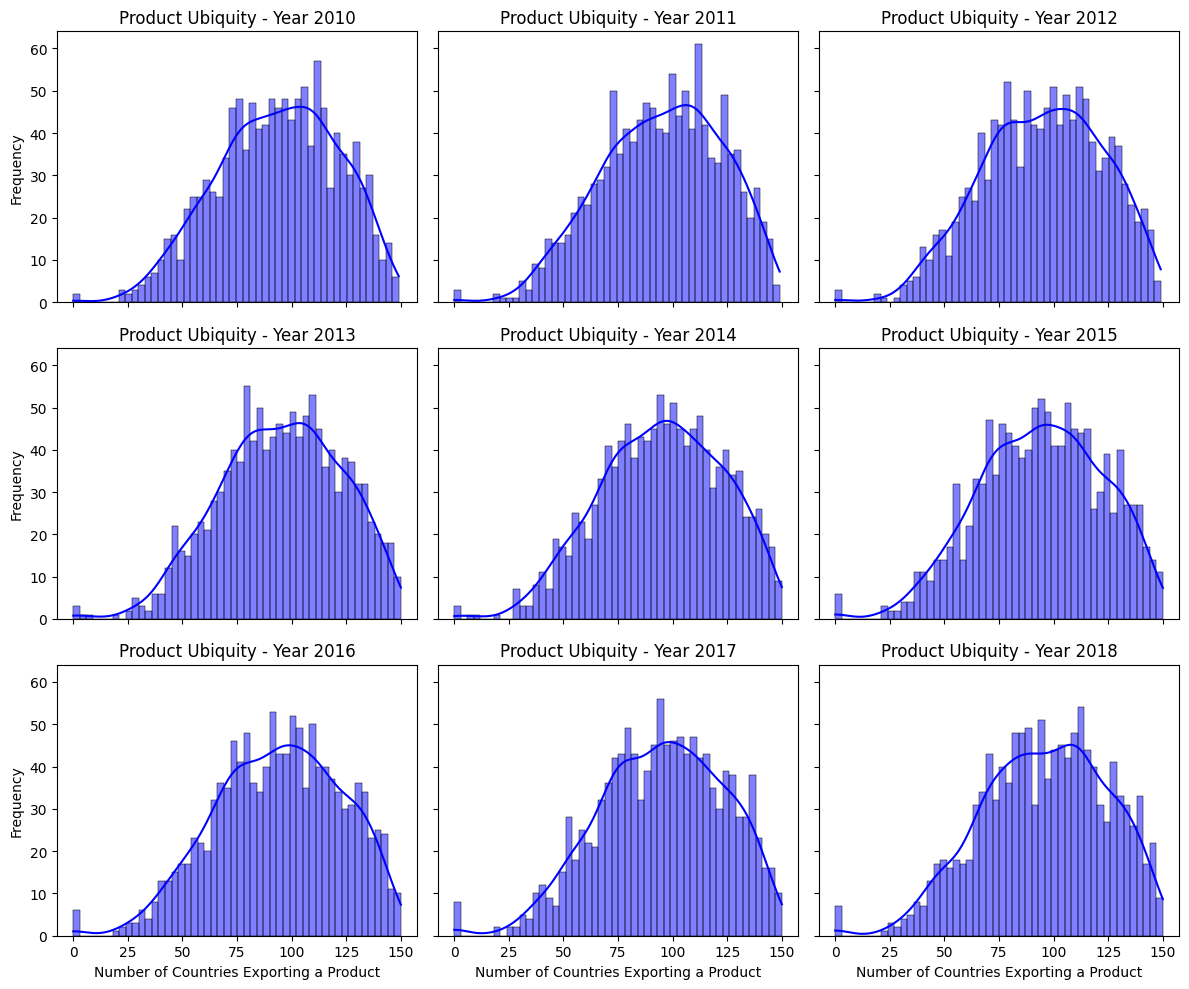

In [53]:
# Now, instead of a single distribution, we will generate multiple histograms (one for each year) to compare how product ubiquity changes over time.
plot_product_ubiquity(clean_sparce_df, product_country_counts)

In [54]:
# assert False, "End of code"

### Removing Products with Zero Export Value for More Than 80% of Countries
**Ensuring Statistical Significance:** If a product is rarely exported (zero exports in >80% of cases), it likely provides little useful information for modeling country-product relationships.</br></br>
**Avoiding Sparse Matrices:** Economic network analysis, especially if using vector-based or graph-based methods, benefits from reducing sparsity. Too many zero values can lead to issues like weak signal extraction and poor statistical properties.

In [55]:
clean_df = clean_sparce_df.copy()

In [56]:
# Count the number of unique exporting countries for each product per year
product_country_counts = clean_df.groupby(["year", "product_id"], observed=False)[
    "country_id"
].nunique()

# Count the total number of countries in each year
total_countries = clean_df.groupby("year", observed=False)["country_id"].nunique()

In [57]:
# Keeping only products exported by more than 20% of countries in each year
ubiq_threshold = 0.2

# Extracting valid product-year pairs as an index
valid_products = product_country_counts[
    product_country_counts / total_countries > ubiq_threshold
].index

In [58]:
dirty_df = clean_df[
    ~clean_df.set_index(["year", "product_id"]).index.isin(valid_products)
].reset_index(drop=True)

In [59]:
clean_df = clean_df[
    clean_df.set_index(["year", "product_id"]).index.isin(valid_products)
].reset_index(drop=True)

In [60]:
df_stats(clean_df, "clean_df")

['clean_df', <class 'pandas.core.frame.DataFrame'>]
shape:
(26520736, 4)
data types:
country_id      category
year            category
product_id      category
export_value       int64
dtype: object
columns:
['country_id', 'year', 'product_id', 'export_value']
            export_value
count      26,520,736.00
mean        6,184,405.67
std       166,384,973.04
min             5,000.00
25%            21,773.00
50%            95,907.00
75%           633,748.00
max   127,254,781,879.00
Total memory usage: 344796074 bytes


In [61]:
low_export_ids = set(dirty_df["product_id"].unique())
print(len(low_export_ids))
print(*low_export_ids)

24
1283 1798 906 1435 684 1586 1859 1860 965 1226 1227 1228 843 1230 845 1231 981 1245 874 1259 1261 755 885 892


In [62]:
categorical_columns = ["product_id", "product_name"]

input_file_name = "product_id_names.parquet"
product_df = read_hs92_parquet_data(
    input_file_location, input_file_name, categorical_columns=categorical_columns
)

product_id column initial type:
int16
product_id column final type:
category
product_name column initial type:
category
product_name column final type:
category


In [63]:
categorical_columns = ["product_id", "product_name"]
product_df = switch_to_dtype(
    product_df, default_dtype="str", categorical_columns=categorical_columns
)

product_id column initial type:
category
product_id column final type:
object
product_name column initial type:
category
product_name column final type:
object


In [64]:
low_export_ids_df = pd.DataFrame(
    {"product_id": dirty_df["product_id"].unique().astype(str)}
)

Verifying which products were identified as rarely exported

In [65]:
low_export_ids_df.merge(product_df, how="left", on="product_id")

,product_id,product_name
0,1226,Silkworm cocoons
1,1227,Raw silk
2,1228,Silk waste
3,755,Copra
4,885,Cobalt ore
5,1230,Yarn from silk waste
6,874,Asbestos
7,843,Solid peanut residues
8,845,Wine lees
9,684,Brushmaking hair


In [66]:
# assert False, "End of code"

In [67]:
del dirty_df
gc.collect()

449

In [68]:
sparsity_col_name = "clean_average_sparsity"

# We will now calculate sparsity for each year separately, rather than across all years.
product_country_counts, clean_sparsity_summary = estimate_average_sparsity(
    clean_df, sparsity_col_name=sparsity_col_name
)

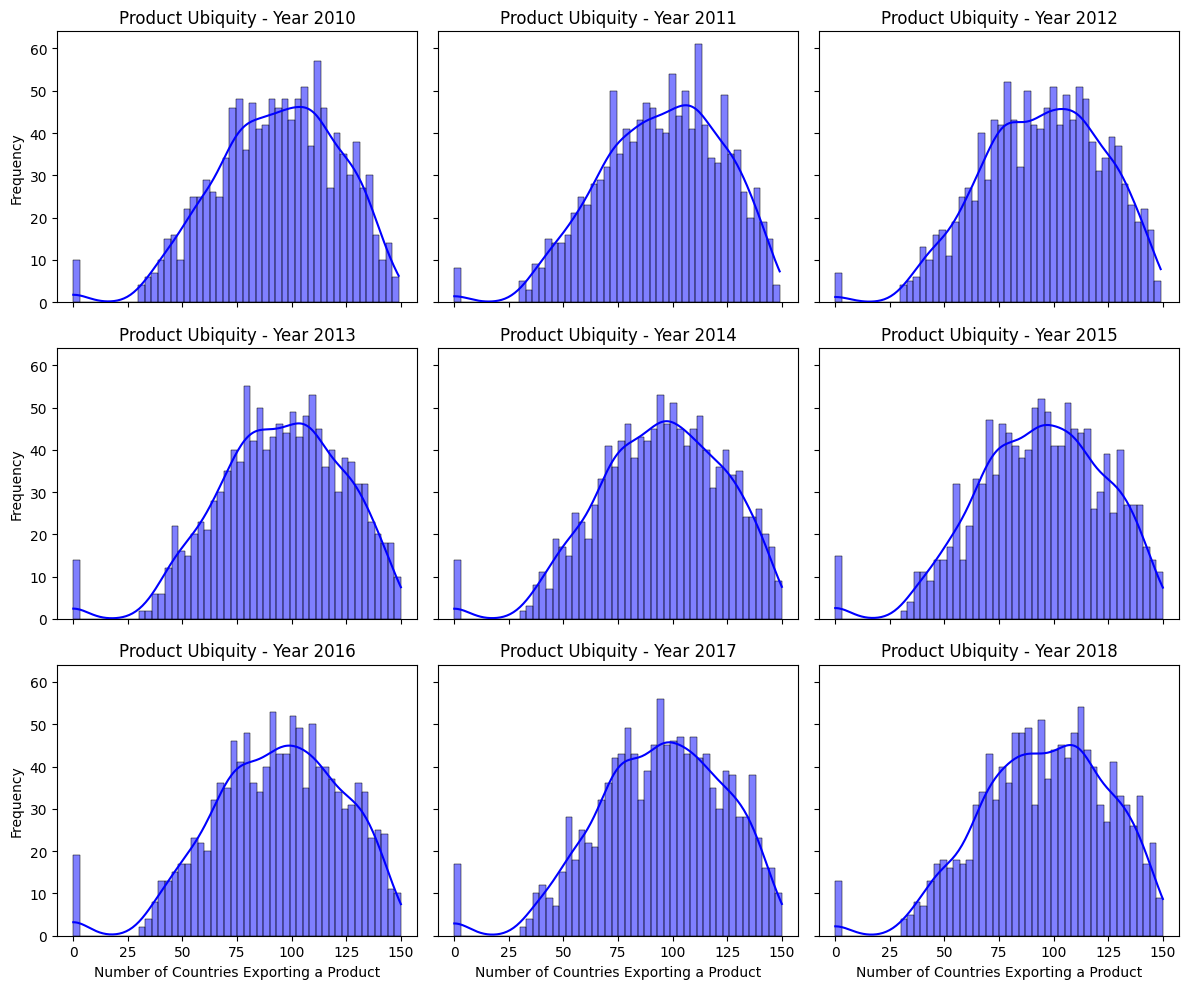

In [69]:
# Now, instead of a single distribution, we will generate multiple histograms (one for each year) to compare how product ubiquity changes over time.
plot_product_ubiquity(clean_df, product_country_counts)

Analyzing how sparsity changed after performing this step of cleaning

In [70]:
joint_sparsity = sparsity_summary.merge(clean_sparsity_summary, how="inner", on="year")
joint_sparsity

,year,average_sparsity,clean_average_sparsity
0,2010,0.370864,0.371953
1,2011,0.361476,0.362119
2,2012,0.367366,0.367835
3,2013,0.367759,0.369129
4,2014,0.368660,0.370117
5,2015,0.373000,0.374251
6,2016,0.374518,0.376375
7,2017,0.369113,0.370412
8,2018,0.363827,0.364668
9,2019,0.365837,0.366514


### From comparison above, I don't see any significant difference in sparsity level.</br>So I keeping this step only for consistency and comparability with works of other authors

In [71]:
# clean_df = clean_sparce_df.copy()

In [72]:
# assert False, "End of code"

In [73]:
del clean_sparce_df, joint_sparsity
gc.collect()

49142

### Removing Countries Whose Exports Are Zero for 95% of Products
**Meaningful contribution:** Ensure that only countries with sufficiently diverse export portfolios remain

In [74]:
# Count how many unique products each country exports each year
country_product_counts = clean_df.groupby(["year", "country_id"], observed=False)[
    "product_id"
].nunique()

# Count total number of unique products exported by any country each year
total_products = clean_df.groupby("year", observed=False)["product_id"].nunique()

In [75]:
# Keeping only countries, which export at least 5% of the total available products.
diverse_threshold = 0.05

# Extracting valid country-year pairs as an index
valid_countries = country_product_counts[
    country_product_counts / total_products > diverse_threshold
].index

In [76]:
dirty_df = clean_df[
    ~clean_df.set_index(["year", "country_id"]).index.isin(valid_countries)
].reset_index(drop=True)

In [77]:
clean_df = clean_df[
    clean_df.set_index(["year", "country_id"]).index.isin(valid_countries)
].reset_index(drop=True)

In [78]:
df_stats(clean_df, "clean_df")

['clean_df', <class 'pandas.core.frame.DataFrame'>]
shape:
(26520065, 4)
data types:
country_id      category
year            category
product_id      category
export_value       int64
dtype: object
columns:
['country_id', 'year', 'product_id', 'export_value']
            export_value
count      26,520,065.00
mean        6,184,115.02
std       166,384,514.44
min             5,000.00
25%            21,773.00
50%            95,912.00
75%           633,767.00
max   127,254,781,879.00
Total memory usage: 344787351 bytes


In [79]:
low_export_ids = set(dirty_df["product_id"].unique())
print(len(low_export_ids))
print(*low_export_ids)

255
1035 1549 1038 1037 1040 1042 1044 1045 1572 1597 1599 1600 1601 1092 1094 1095 1614 1615 1616 1135 1618 1108 1110 1623 1112 1114 1627 1116 1629 1630 1631 1633 1636 1637 1638 1639 1130 1643 1645 1646 1647 1648 1649 1137 1138 1139 1141 1142 1140 1656 1650 1659 1660 1661 1149 1155 1159 1160 1164 653 654 1166 656 1169 658 659 1683 1689 666 1691 1692 1690 670 1695 672 1184 1697 675 1699 1187 671 1703 1191 1696 1704 1707 1195 1708 1705 681 1709 1201 690 1715 1714 1718 1720 1721 1209 1724 700 704 1728 1729 1731 1732 1221 710 712 1737 714 1739 715 718 1744 1745 721 1747 1746 726 729 1246 1247 1760 1761 1250 1763 1764 1253 739 741 1768 1765 1766 750 754 1779 1778 1782 759 1784 760 763 1789 1790 767 768 766 1278 772 1800 1289 1803 1804 781 1807 783 1810 1811 787 1303 1816 1817 1815 1819 1820 1821 799 1824 811 1326 814 818 819 1843 1334 1335 823 1338 673 829 1853 831 832 1855 1856 837 1350 1351 1352 1353 1354 1355 1357 847 1359 848 850 851 678 1364 1368 1370 1373 1374 1888 1889 866 867 1891 

In [80]:
del dirty_df
gc.collect()

48784

## Looking for countries which are not present across all years

In [81]:
# Count the number of unique years each country appears in
country_year_counts = clean_df.groupby("country_id", observed=False)["year"].nunique()

In [82]:
# Identify countries that do not appear in all years
missing_years_country_ids = country_year_counts[
    country_year_counts < len(export_years)
].index

In [83]:
missing_years_country_ids = set(
    clean_df[clean_df["country_id"].isin(missing_years_country_ids)][
        "country_id"
    ].unique()
)

In [84]:
missing_years_country_ids

{232, 728}

In [85]:
# Remove these countries from the dataset. Reset index to optimize memory layout. Works very quickly for categories instead of objects
clean_df = clean_df[
    ~clean_df["country_id"].isin(missing_years_country_ids)
].reset_index(drop=True)

In [86]:
# Force garbage collection before continuing
del missing_years_country_ids
gc.collect()

0

In [87]:
unique_countries = set(clean_df["country_id"].unique())

In [88]:
print("Unique countries after filtering:", len(unique_countries))

Unique countries after filtering: 148


In [89]:
# Remove unused categories to free up memory. Actually there should not be, but...
clean_df["country_id"] = clean_df["country_id"].cat.remove_unused_categories()

In [90]:
unique_countries = set(clean_df["country_id"].unique())

In [91]:
print("Unique countries after filtering:", len(unique_countries))

Unique countries after filtering: 148


In [92]:
df_stats(clean_df)

['df', <class 'pandas.core.frame.DataFrame'>]
shape:
(26519175, 4)
data types:
country_id      category
year            category
product_id      category
export_value       int64
dtype: object
columns:
['country_id', 'year', 'product_id', 'export_value']
            export_value
count      26,519,175.00
mean        6,184,153.30
std       166,386,943.15
min             5,000.00
25%            21,774.00
50%            95,918.00
75%           633,801.00
max   127,254,781,879.00
Total memory usage: 344773145 bytes


In [93]:
# Save the clean exports Data to a .parquet file
output_file_name = "clean_exports.parquet"
save_hs92_parquet_data(
    data=clean_df, file_location=output_file_location, file_name=output_file_name
)

country_id column initial type:
category
country_id column final type:
int16
product_id column initial type:
category
product_id column final type:
int16
year column initial type:
category
year column final type:
int16


In [94]:
del clean_df
gc.collect()

0

## Ensuring reliable data

To flag a country as 'unreliable', usually applied following assumptions:
1. Conflict or Political Instability
    * Countries affected by wars tend to have disrupted trade reporting.
    * Example: Iraq and Afghanistan have histories of trade sanctions and missing data.
2. Data Volatility and Gaps
    * Countries with significant missing years or erratic export trends are considered unreliable.
    * Example: Macau is sometimes excluded because of its unique status as a free-trade hub with inconsistent trade reporting.
3. Export-to-GDP Imbalance
    * Some countries report exports that do not align with their economic size.
    * Example: Chad is often flagged because of low economic activity but high-reported trade fluctuations.

| **Country**         | **Why Excluded?**                                      |
|-------------------------|------------------------------------------------------|
|Iraq (IRQ) | Data gaps due to war and sanctions; unreliable trade statistics.|
|Chad (TCD)	| Extreme fluctuations in trade data, suspected statistical errors.|
|Macau (MAC) | Unique status as a free-trade zone causes inconsistent trade reporting.|
|Afghanistan (AFG) | Conflict-related disruptions, high dependence on aid and illicit trade.|

Mentioned countries are commonly considered as reporting unreliable data and excluded from ECI estimation process. We are going to exclude them since we don't have any specific reason to keep them.

In [95]:
# # Resolve the path to the 'src' folder with helper functions
# import config_notebooks
# from importlib import reload

# # Import the module and reload it
# import n03_import_reload

# reload(n03_import_reload)

# # Re-import the functions from the reloaded module
# from n03_import_reload import *

In [96]:
input_file_name = "clean_exports.parquet"
reliable_df = read_hs92_parquet_data(
    output_file_location, input_file_name, f_convert_dtype=False
)

In [97]:
reliable_df.dtypes

country_id      int16
year            int16
product_id      int16
export_value    int64
dtype: object

In [98]:
# Economies which are commonly considered reporting unreliable data such as Iraq (IRQ), Chad  (TCD), Macau (MAC), Afghanistan (AFG)
# List of unreliable country codes
unreliable_codes = ["IRQ", "TCD", "MAC", "AFG"]

In [99]:
input_file_name = "locations.parquet"
location_df = read_hs92_parquet_data(
    input_file_location, input_file_name, f_convert_dtype=False
)

In [100]:
location_df.dtypes

country_id       int16
country_name    object
country_code    object
dtype: object

In [101]:
# Making sure that were chosen correct country codes
unreliable_locations = location_df[location_df["country_code"].isin(unreliable_codes)]
unreliable_locations

,country_id,country_name,country_code
1,4,Afghanistan,AFG
108,368,Iraq,IRQ
133,446,Macao,MAC
214,148,Chad,TCD


In [102]:
dumped_data["unreliable_locations"] = unreliable_locations

staging_cache(output_file_location=input_file_location, **dumped_data)

data staged:['valid_gdp_country_codes', 'valid_gdp_country_ids', 'valid_gdp_locations', 'export_years', 'unreliable_locations', 'rolling_exports_years', 'reliable_gdp_codes']


In [103]:
# Discarding the rows with the following country ids in unreliable_locations
reliable_df = reliable_df[
    ~reliable_df["country_id"].isin(unreliable_locations["country_id"])
].reset_index(drop=True)

In [104]:
# Save the clean and reliable exports Data to a .parquet file
output_file_name = "reliable_exports.parquet"
save_hs92_parquet_data(
    data=reliable_df, file_location=output_file_location, file_name=output_file_name
)

country_id column initial type:
int16
country_id column final type:
int16
product_id column initial type:
int16
product_id column final type:
int16
year column initial type:
int16
year column final type:
int16


In [105]:
del reliable_df
gc.collect()

0

In [106]:
# assert False, "End of code"

# Summarizing country-product exports

In [107]:
# all_col_names = ['country_id', 'partner_country_id', 'year', 'product_id', 'export_value', 'import_value', 'coi', 'eci', 'pci']
# col_names = ['country_id', 'year', 'product_id', 'export_value']

input_file_name = "reliable_exports.parquet"
product_exports_total = read_hs92_parquet_data(output_file_location, input_file_name)

country_id column initial type:
int16
country_id column final type:
category
product_id column initial type:
int16
product_id column final type:
category
year column initial type:
int16
year column final type:
category


In [108]:
df_stats(product_exports_total)

['df', <class 'pandas.core.frame.DataFrame'>]
shape:
(26501863, 4)
data types:
country_id      category
year            category
product_id      category
export_value       int64
dtype: object
columns:
['country_id', 'year', 'product_id', 'export_value']
            export_value
count      26,501,863.00
mean        6,145,125.21
std       161,480,470.44
min             5,000.00
25%            21,788.00
50%            95,997.00
75%           634,265.00
max   127,254,781,879.00
Total memory usage: 344550701 bytes


In [109]:
# # Better to switch to string data type for categorical columns before grouping
# categorical_columns = ['country_id', 'product_id', 'year']
# raw_df = switch_to_dtype(raw_df, default_dtype='str', categorical_columns=categorical_columns, f_convert_integers=False)

In [110]:
# Summarizing the exports_value data across country_id, product_id and year
product_exports_total = (
    product_exports_total.groupby(["country_id", "product_id", "year"], observed=False)[
        "export_value"
    ]
    .sum()
    .reset_index()
)

In [111]:
df_stats(product_exports_total)

['df', <class 'pandas.core.frame.DataFrame'>]
shape:
(1760300, 4)
data types:
country_id      category
product_id      category
year            category
export_value       int64
dtype: object
columns:
['country_id', 'product_id', 'year', 'export_value']
            export_value
count       1,760,300.00
mean       92,516,767.81
std     1,441,150,420.14
min                 0.00
25%                 0.00
50%            99,082.00
75%         4,317,080.75
max   371,680,640,697.00
Total memory usage: 22910382 bytes


In [112]:
product_exports_total.sample(10)

,country_id,product_id,year,export_value
496491,250,1764,2011,4207231490
618183,332,1793,2013,0
307608,170,1068,2018,0
1336953,688,810,2013,7262811
1199490,598,1652,2010,0
87526,50,911,2016,37169603
110664,56,795,2014,123075064
1157472,578,1075,2012,672373
564895,288,1309,2015,0
1037181,504,1187,2011,57673296


In [113]:
# Exploring the exports_summary data
product_exports_total_unstacked = product_exports_total.pivot(
    index=["country_id", "product_id"], columns="year", values=["export_value"]
)
product_exports_total_unstacked.sample(10)

export_value                                   \
year                          2010       2011       2012       2013   
country_id product_id                                                 
384        1803              19766       6590     126693     185540   
860        1778             142029     576319    5121926    1229206   
108        929                   0          0          0          0   
528        1848             568043     424210     454314     632580   
716        1359                  0       7412          0          0   
398        1560          195706793  421406154  345857074  234504675   
710        1671             822964     617490    1003569     921011   
434        1838                  0          0          0          0   
320        1349           21530695   24302297   27255607   25069428   
404        1340           20518520   38705098   29514201   27682726   

                                                                              \
year                        2014       2015       2016       2017       2018   
country_id product_id                                                          
384        1803           272467     583470     693011     209683    1366005   
860        1778           220085    1110581     152101          0    2018136   
108        929                 0          0          0          0          0   
528        1848           469805     424994     261196     311257     374722   
716        1359                0          0          0          0          0   
398        1560        371457124  276311642  258437773  275429797  335373721   
710        1671          2908454    1702556     999544     760711     700009   
434        1838                0          0          0          0          0   
320        1349         22529204   21485298   11857577    9654644   11735941   
404        1340         44305349   10488476    9605609   18948959   23136650   

                                  
year                        2019  
country_id product_id             
384        1803          1508870  
860        1778         12147525  
108        929                 0  
528        1848           894699  
716        1359                0  
398        1560        183834126  
710        1671           546208  
434        1838                0  
320        1349          8929523  
404        1340         29616492

In [114]:
del product_exports_total_unstacked
gc.collect()

0

### Calculating exports rolling average

In [115]:
product_exports_total.head()

,country_id,product_id,year,export_value
0,8,650,2010,0
1,8,650,2011,0
2,8,650,2012,0
3,8,650,2013,539813
4,8,650,2014,0


In [116]:
# Calculating 'product by country exports rolling average'.
# This xslutio avoids the overhead of double transpositions and directly operates on the sorted product_exports DF
# using groupby and transform, which is optimized for such operations in pandas

# Sort the DataFrame by 'country_id', 'product_id' and 'year' to ensure correct rolling window calculation
product_exports_total = product_exports_total.sort_values(
    by=["country_id", "product_id", "year"]
)

# Group by 'country_id' and 'product_id' and apply 3-month rolling average of 'export_value' for each country-product pair
product_exports_total["average_export_value"] = product_exports_total.groupby(
    ["country_id", "product_id"], observed=False
)["export_value"].transform(lambda x: x.rolling(window=3).mean())

In [117]:
df_stats(product_exports_total)

['df', <class 'pandas.core.frame.DataFrame'>]
shape:
(1760300, 5)
data types:
country_id              category
product_id              category
year                    category
export_value               int64
average_export_value     float64
dtype: object
columns:
['country_id', 'product_id', 'year', 'export_value', 'average_export_value']
            export_value  average_export_value
count       1,760,300.00          1,408,240.00
mean       92,516,767.81         92,694,429.21
std     1,441,150,420.14      1,431,323,301.33
min                 0.00                  0.00
25%                 0.00                  0.00
50%            99,082.00            132,606.33
75%         4,317,080.75          4,608,486.33
max   371,680,640,697.00    359,983,930,717.33
Total memory usage: 36992782 bytes


Staging total product exports along with rolling average. We call it raw_ because it is with missing values

In [118]:
# Save the product_exports_total average Data to a raw_product_exports_total.parquet file
output_file_name = "raw_product_exports_total.parquet"
save_hs92_parquet_data(
    data=product_exports_total,
    file_location=output_file_location,
    file_name=output_file_name,
)

country_id column initial type:
category
country_id column final type:
int16
product_id column initial type:
category
product_id column final type:
int16
year column initial type:
category
year column final type:
int16


In [119]:
del product_exports_total
gc.collect()

0

In [120]:
# assert False, "End of code"

Reading raw total product exports

In [121]:
col_names = ["country_id", "product_id", "year", "average_export_value"]

input_file_name = "raw_product_exports_total.parquet"
product_rolling_exports = read_hs92_parquet_data(
    output_file_location, input_file_name, columns=col_names
)

country_id column initial type:
int16
country_id column final type:
category
product_id column initial type:
int16
product_id column final type:
category
year column initial type:
int16
year column final type:
category


In [122]:
# product_rolling_exports = product_exports_total.copy()
product_rolling_exports.head(15)

,country_id,product_id,year,average_export_value
0,8,650,2010,NaN
1,8,650,2011,NaN
2,8,650,2012,0.00
3,8,650,2013,"179,937.67"
4,8,650,2014,"179,937.67"
5,8,650,2015,"179,937.67"
6,8,650,2016,0.00
7,8,650,2017,0.00
8,8,650,2018,0.00
9,8,650,2019,0.00


In [123]:
# Filter out rows where the rolling average could not be calculated (first two years for each country)
product_rolling_exports.dropna(subset=["average_export_value"], inplace=True)
product_rolling_exports.head(15)

,country_id,product_id,year,average_export_value
2,8,650,2012,0.00
3,8,650,2013,"179,937.67"
4,8,650,2014,"179,937.67"
5,8,650,2015,"179,937.67"
6,8,650,2016,0.00
7,8,650,2017,0.00
8,8,650,2018,0.00
9,8,650,2019,0.00
12,8,651,2012,0.00
13,8,651,2013,"87,674.67"


In [124]:
df_stats(product_rolling_exports)

['df', <class 'pandas.core.frame.DataFrame'>]
shape:
(1408240, 4)
data types:
country_id              category
product_id              category
year                    category
average_export_value     float64
dtype: object
columns:
['country_id', 'product_id', 'year', 'average_export_value']
       average_export_value
count          1,408,240.00
mean          92,694,429.21
std        1,431,323,301.33
min                    0.00
25%                    0.00
50%              132,606.33
75%            4,608,486.33
max      359,983,930,717.33
Total memory usage: 29599390 bytes


In [125]:
# Exploring the product_rolling_exports data
product_rolling_exports_unstacked = product_rolling_exports.pivot(
    index=["country_id", "product_id"], columns="year", values=["average_export_value"]
)
product_rolling_exports_unstacked.sample(10)

average_export_value                                \
year                                  2012           2013           2014   
country_id product_id                                                      
430        1150                   4,566.00       4,566.00           0.00   
784        1133               7,327,600.33   7,996,723.67   8,475,702.00   
768        1307                       0.00      17,511.33      17,511.33   
144        1026                       0.00           0.00       1,972.67   
764        814              232,044,444.67 264,475,270.33 290,246,151.33   
12         887                  960,296.33     156,557.67     156,557.67   
558        1333              16,414,201.67  30,063,294.33  57,238,474.00   
270        1508                       0.00       5,674.67       5,674.67   
768        1507                 944,929.33     828,201.00     710,097.00   
703        1611                 235,046.00     163,529.33     118,759.33   

                                                                    \
year                            2015           2016           2017   
country_id product_id                                                
430        1150                 0.00           0.00           0.00   
784        1133         3,092,981.00   2,731,447.00   5,894,915.00   
768        1307            17,511.33           0.00           0.00   
144        1026             7,828.67      10,482.00      12,328.67   
764        814        318,353,999.33 340,514,507.00 365,589,158.00   
12         887                  0.00   1,142,349.33   2,425,136.67   
558        1333        66,019,212.33  65,773,501.00  52,615,871.33   
270        1508             5,674.67           0.00           0.00   
768        1507           405,387.00     201,868.67      94,761.00   
703        1611           157,851.33     265,451.00     433,202.67   

                                                     
year                            2018           2019  
country_id product_id                                
430        1150                 0.00       2,891.67  
784        1133        16,893,712.67  24,861,503.00  
768        1307                 0.00           0.00  
144        1026            10,652.00      13,207.67  
764        814        390,327,332.67 414,632,431.67  
12         887          2,721,070.33   1,578,721.00  
558        1333        46,377,435.33  47,473,955.00  
270        1508                 0.00           0.00  
768        1507           102,904.00     159,555.67  
703        1611           532,989.33     598,939.33

Staging product rolling exports. Actually "product rolling exports" is location–activity matrix Xcp. 

In [126]:
# Save the product_rolling_exports average Data to a .parquet file
output_file_name = "product_rolling_exports.parquet"
save_hs92_parquet_data(
    data=product_rolling_exports,
    file_location=output_file_location,
    file_name=output_file_name,
)

country_id column initial type:
category
country_id column final type:
int16
product_id column initial type:
category
product_id column final type:
int16
year column initial type:
category
year column final type:
int16


In [ ]:
# Save the product_rolling_exports average Data to a .parquet file
output_file_name = "raw_X_cp.parquet"
save_hs92_parquet_data(
    data=product_rolling_exports,
    file_location=output_file_location,
    file_name=output_file_name,
)

country_id column initial type:
category
country_id column final type:
int16
product_id column initial type:
category
product_id column final type:
int16
year column initial type:
category
year column final type:
int16


In [128]:
dumped_data["rolling_exports_years"] = set(product_rolling_exports["year"].unique())

staging_cache(output_file_location=input_file_location, **dumped_data)

data staged:['valid_gdp_country_codes', 'valid_gdp_country_ids', 'valid_gdp_locations', 'export_years', 'unreliable_locations', 'rolling_exports_years', 'reliable_gdp_codes']


In [129]:
del product_rolling_exports, product_rolling_exports_unstacked
gc.collect()

0

In [130]:
# assert False, "End of code"

# Summarizing total country-level exports

In [131]:
col_names = ["country_id", "year", "export_value"]

input_file_name = "raw_product_exports_total.parquet"
country_exports_total = read_hs92_parquet_data(
    output_file_location, input_file_name, columns=col_names
)

country_id column initial type:
int16
country_id column final type:
category
year column initial type:
int16
year column final type:
category


In [132]:
# Summarizing the exports_value data across country and year
country_exports_total = (
    country_exports_total.groupby(["country_id", "year"], observed=False)[
        "export_value"
    ]
    .sum()
    .reset_index()
)

In [133]:
df_stats(country_exports_total)

['df', <class 'pandas.core.frame.DataFrame'>]
shape:
(1450, 3)
data types:
country_id      category
year            category
export_value       int64
dtype: object
columns:
['country_id', 'year', 'export_value']
              export_value
count             1,450.00
mean    112,315,356,118.68
std     269,142,722,787.11
min          73,553,867.00
25%       3,630,718,268.75
50%      13,847,902,146.50
75%      94,710,036,749.00
max   2,468,483,493,200.00
Total memory usage: 19228 bytes


In [134]:
country_exports_total.head(15)

,country_id,year,export_value
0,8,2010,1596114928
1,8,2011,1954231052
2,8,2012,1978862984
3,8,2013,2540723872
4,8,2014,2527803546
5,8,2015,2005707313
6,8,2016,2055737037
7,8,2017,2340459217
8,8,2018,2747924814
9,8,2019,2730367990


In [135]:
# country_exports_total = switch_to_dtype(country_exports_total, default_dtype='int16', categorical_columns=['country_id', 'year'])

# Sort the DataFrame by country and year
country_exports_total = country_exports_total.sort_values(by=["country_id", "year"])

# country_exports_total = switch_to_dtype(country_exports_total, default_dtype='str', categorical_columns=['country_id', 'year'])

In [136]:
country_exports_total[
    country_exports_total.duplicated(subset=["country_id", "year"], keep=False)
]

,country_id,year,export_value


In [137]:
# Exploring the exports_summary data
country_exports_unstacked = country_exports_total.pivot(
    index=["country_id"], columns="year", values=["export_value"]
)
country_exports_unstacked.sample(10)

export_value                                            \
year                2010          2011          2012          2013   
country_id                                                           
434          41714799640   16138990227   48991798433   35434764153   
430            811354216     829664384    1100892192    1122144916   
562            321686567     493044787     998047130    1898980227   
70            4316750567    5458902941    4905181137    5398861022   
178          10232840438   10924816114    9378327809   10167499336   
440          18246295279   25198442963   26728765514   27446181368   
218          18103531580   23598871389   24977531192   24502502727   
729          10647960138   12630638720    4942707174   11670354508   
108             87347555     163809315     380429436     250349519   
792         111918115010  132170952754  148794833030  156306329352   

                                                                    \
year                2014          2015          2016          2017   
country_id                                                           
434          17318212128    9548168120   10904699715   17877509102   
430           1234238004    1496341506     868261362    1076243656   
562            671719501     713645878     583299171     647729013   
70            5775655057    4977918497    5226777272    5979080314   
178          10601701550    8250362944    6723077538    7442084954   
440          27921519687   21500472799   21257991333   24799563050   
218          27532956483   18130945108   16679370147   18486102410   
729           5066776025    3434827225    3304680151    4280191740   
108            242757058     211132091     157600620     144865625   
792         160587959224  146361153410  143946558314  157485974711   

                                        
year                2018          2019  
country_id                              
434          28210052936   29806898256  
430           1183994577    1155315663  
562            621729763     854398244  
70            6756703691    6311020484  
178          11291624853    8655487392  
440          28557762582   28931724735  
218          20964006012   22250745505  
729           3827331456    3360808612  
108            196696301     207785851  
792         172700887421  175198946000

In [138]:
country_exports_unstacked.shape

(145, 10)

In [139]:
del country_exports_unstacked
gc.collect()

0

In [140]:
# Calculating 'country exports rolling average'. Solution 2
# It is superior in terms of both efficiency and long-term maintainability.
# It avoids the overhead of double transpositions and directly operates on the sorted DataFrame using groupby and transform, which is optimized for such operations in pandas

# country_exports_total = switch_to_dtype(country_exports_total, default_dtype='int16', categorical_columns=['country_id', 'year'])

# Sort the DataFrame by 'country_id' and 'year' to ensure correct rolling window calculation
country_exports_total = country_exports_total.sort_values(by=["country_id", "year"])

# country_exports_total = switch_to_dtype(country_exports_total, default_dtype='str', categorical_columns=['country_id', 'year'])

# Group by 'country_id' and apply rolling average on 'export_value'
country_exports_total["average_export_value"] = country_exports_total.groupby(
    ["country_id"], observed=False
)["export_value"].transform(lambda x: x.rolling(window=3).mean())

In [141]:
df_stats(country_exports_total)

['df', <class 'pandas.core.frame.DataFrame'>]
shape:
(1450, 4)
data types:
country_id              category
year                    category
export_value               int64
average_export_value     float64
dtype: object
columns:
['country_id', 'year', 'export_value', 'average_export_value']
              export_value  average_export_value
count             1,450.00              1,160.00
mean    112,315,356,118.68    112,531,037,061.54
std     269,142,722,787.11    269,461,923,213.84
min          73,553,867.00         85,456,830.00
25%       3,630,718,268.75      3,809,652,423.33
50%      13,847,902,146.50     14,104,899,439.67
75%      94,710,036,749.00     99,468,218,391.25
max   2,468,483,493,200.00  2,402,043,349,141.67
Total memory usage: 30828 bytes


Staging total country-level exports along with rolling average. We call it raw_ because it is with missing values

In [142]:
# Save the product_rolling_exports average Data to a .parquet file
output_file_name = "raw_country_total_exports.parquet"
save_hs92_parquet_data(
    data=country_exports_total,
    file_location=output_file_location,
    file_name=output_file_name,
)

country_id column initial type:
category
country_id column final type:
int16
year column initial type:
category
year column final type:
int16


In [143]:
del country_exports_total
gc.collect()

0

In [144]:
col_names = ["country_id", "year", "average_export_value"]

input_file_name = "raw_country_total_exports.parquet"
country_rolling_exports = read_hs92_parquet_data(
    output_file_location, input_file_name, columns=col_names
)

country_id column initial type:
int16
country_id column final type:
category
year column initial type:
int16
year column final type:
category


In [145]:
# country_rolling_exports = country_exports_total.copy()
country_rolling_exports.head(15)

,country_id,year,average_export_value
0,8,2010,NaN
1,8,2011,NaN
2,8,2012,"1,843,069,654.67"
3,8,2013,"2,157,939,302.67"
4,8,2014,"2,349,130,134.00"
5,8,2015,"2,358,078,243.67"
6,8,2016,"2,196,415,965.33"
7,8,2017,"2,133,967,855.67"
8,8,2018,"2,381,373,689.33"
9,8,2019,"2,606,250,673.67"


In [146]:
# Filter out rows where the rolling average could not be calculated (first two years for each country)
country_rolling_exports.dropna(subset=["average_export_value"], inplace=True)
country_rolling_exports.head(10)

,country_id,year,average_export_value
2,8,2012,"1,843,069,654.67"
3,8,2013,"2,157,939,302.67"
4,8,2014,"2,349,130,134.00"
5,8,2015,"2,358,078,243.67"
6,8,2016,"2,196,415,965.33"
7,8,2017,"2,133,967,855.67"
8,8,2018,"2,381,373,689.33"
9,8,2019,"2,606,250,673.67"
12,12,2012,"62,368,091,063.33"
13,12,2013,"65,459,561,086.67"


In [147]:
df_stats(country_rolling_exports)

['df', <class 'pandas.core.frame.DataFrame'>]
shape:
(1160, 3)
data types:
country_id              category
year                    category
average_export_value     float64
dtype: object
columns:
['country_id', 'year', 'average_export_value']
       average_export_value
count              1,160.00
mean     112,531,037,061.54
std      269,461,923,213.84
min           85,456,830.00
25%        3,809,652,423.33
50%       14,104,899,439.67
75%       99,468,218,391.25
max    2,402,043,349,141.67
Total memory usage: 25186 bytes


In [148]:
# Exploring the rolling_exports data
country_rolling_exports_unstacked = country_rolling_exports.pivot(
    index=["country_id"], columns="year", values=["average_export_value"]
)
country_rolling_exports_unstacked.sample(10)

average_export_value                                        \
year                       2012               2013               2014   
country_id                                                              
705           25,769,792,303.33  27,487,540,657.00  28,209,079,269.00   
498            2,036,360,410.33   2,276,797,278.00   2,340,656,180.00   
116            6,879,464,841.00   7,877,822,088.67   8,879,350,419.00   
554           33,837,352,453.00  36,719,872,850.00  38,062,315,686.33   
218           22,226,644,720.33  24,359,635,102.67  25,670,996,800.67   
204            1,252,276,161.67   1,143,904,405.67   1,188,676,537.67   
24            60,179,029,054.33  67,910,637,706.33  64,818,337,567.33   
250          538,299,520,131.67 556,209,519,536.67 551,244,242,664.67   
410          520,552,369,597.33 554,873,543,035.67 566,081,331,886.33   
192            2,588,889,654.00   2,658,067,820.67   2,313,993,340.67   

                                                                     \
year                     2015               2016               2017   
country_id                                                            
705         28,031,721,623.00  27,507,444,945.33  27,622,649,886.67   
498          2,305,582,831.67   2,212,597,194.33   2,234,784,577.00   
116         10,159,493,597.00  11,799,097,858.33  13,224,635,578.67   
554         36,904,031,635.67  34,821,768,294.00  33,637,728,757.33   
218         23,388,801,439.33  20,781,090,579.33  17,765,472,555.00   
204          1,091,469,941.33   1,043,548,672.00     983,154,644.67   
24          52,018,175,452.33  38,013,471,654.33  30,047,687,412.33   
250        531,192,239,493.67 506,684,932,656.00 490,888,431,287.33   
410        553,351,001,536.67 527,450,535,431.67 518,059,861,745.00   
192          1,969,784,370.33   1,785,724,544.00   1,886,862,667.00   

                                                  
year                     2018               2019  
country_id                                        
705         30,687,839,756.67  33,441,964,585.00  
498          2,505,720,034.33   2,771,792,411.00  
116         14,796,831,783.67  17,101,028,388.33  
554         35,545,823,848.33  37,441,125,271.00  
218         18,709,826,189.67  20,566,951,309.00  
204          1,075,106,151.67   1,292,623,948.33  
24          31,418,632,173.00  32,882,319,795.67  
250        513,967,469,269.00 535,192,936,355.67  
410        547,987,347,414.67 563,148,327,180.00  
192          2,075,272,045.67   1,894,752,356.67

Staging total country-level exports rolling average

In [149]:
# Save the country_rolling_exports DataFrame to a .dta file
output_file_name = "country_rolling_exports.parquet"
save_hs92_parquet_data(
    data=country_rolling_exports,
    file_location=output_file_location,
    file_name=output_file_name,
)

country_id column initial type:
category
country_id column final type:
int16
year column initial type:
category
year column final type:
int16


In [150]:
# assert False, "End of code"

In [151]:
del country_rolling_exports_unstacked
gc.collect()

0